In [5]:
import sys
import os
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from quant.Classification import Classification
from quant.factor import get_factors
from tqdm import tqdm

import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

np.set_printoptions(precision=4, suppress=True)

import warnings
warnings.filterwarnings('ignore')

#### Provide attribution to splits

In [2]:
klines_1h_file = 'data/futures_klines_1h_BTCUSDT_20200101_20220430.zip'
kline_1h_df = pd.read_csv(klines_1h_file, index_col=0, parse_dates=True)
kline_1h_factors = get_factors(kline_1h_df, sign_ratio=1)

In [3]:
X = kline_1h_factors.drop(['Price', 'Returns', 'CumReturns', 'Log_Returns', 'Returns_Ratio', 'Sign'], axis=1)
y = kline_1h_factors['Sign']
X.shape, y.shape

((20217, 18), (20217,))

In [4]:
pca = PCA(n_components='mle', svd_solver="full")
pca.fit(X)
print(pca.explained_variance_ratio_)

pca = PCA(n_components=8, svd_solver="full")
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.9735 0.0204 0.0044 0.0009 0.0004 0.0002 0.0001 0.0001 0.     0.
 0.     0.     0.     0.     0.     0.     0.    ]
[0.9735 0.0204 0.0044 0.0009 0.0004 0.0002 0.0001 0.0001]


In [10]:
scores = pd.DataFrame(columns=['test ratio', 'mse', 'rmse', 'r2train', 'r2test'], index=[])

for i in tqdm(np.arange(0.1, 0.6, 0.1)):
    decision_tree = Classification(X_pca, y, test_size=i)
    decision_tree.fit_predict(
        MinMaxScaler(),
        DecisionTreeClassifier(criterion='gini',
                               max_depth=1,
                               max_features=6,
                               min_samples_leaf=1,
                               min_samples_split=2,
                               random_state=64,
                               ccp_alpha=0))
    decision_tree_mse, decision_tree_rmse, decision_tree_r2train, decision_tree_r2test = decision_tree.eval_metrics()
    index = scores.index.size
    scores.loc[index] = [i, decision_tree_mse, decision_tree_rmse, decision_tree_r2train, decision_tree_r2test]

print(scores.to_latex(index=False))
scores

100%|██████████| 5/5 [00:00<00:00, 68.90it/s]

\begin{tabular}{rrrrr}
\toprule
 test ratio &    mse &   rmse &  r2train &  r2test \\
\midrule
     0.1000 & 0.4654 & 0.6822 &   0.5195 &  0.5346 \\
     0.2000 & 0.4933 & 0.7024 &   0.5224 &  0.5067 \\
     0.3000 & 0.4906 & 0.7004 &   0.5235 &  0.5094 \\
     0.4000 & 0.4814 & 0.6938 &   0.5226 &  0.5186 \\
     0.5000 & 0.4871 & 0.6979 &   0.5255 &  0.5129 \\
\bottomrule
\end{tabular}



,test ratio,mse,rmse,r2train,r2test
0,0.1000,0.4654,0.6822,0.5195,0.5346
1,0.2000,0.4933,0.7024,0.5224,0.5067
2,0.3000,0.4906,0.7004,0.5235,0.5094
3,0.4000,0.4814,0.6938,0.5226,0.5186
4,0.5000,0.4871,0.6979,0.5255,0.5129


<AxesSubplot:xlabel='test ratio'>

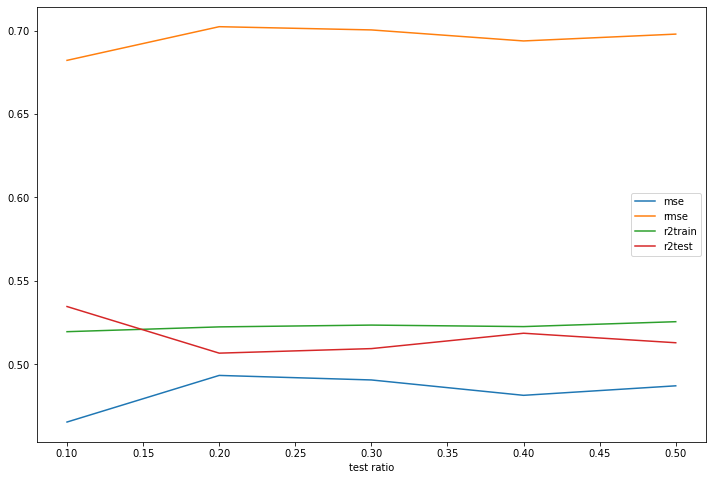

In [11]:
scores.plot(x='test ratio', figsize=(12, 8))

#### Conclusion

The result shows that even the test ratio is from 10\% to 50\%, MSE and R2 Score only changes by 3\% at most. So we can draw a conclusion that the splits are insensible in this experiment. 